# Modelling with PyHealth (using NOTEEVENTS_ICD)

## Libraries

In [1]:
import pandas as pd
import numpy as np

In [ ]:
%pip install torch==2.1.0

In [1]:
import torch
print(torch.__version__)

# Install required packages.
import os
os.environ['TORCH'] = torch.__version__

2.1.0+cpu


In [13]:
%pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
%pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html

Looking in links: https://data.pyg.org/whl/torch-${TORCH}.html
Note: you may need to restart the kernel to use updated packages.
Looking in links: https://data.pyg.org/whl/torch-${TORCH}.html
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install torch-geometric

In [2]:
# carica i dati dai file csv
noteevents = pd.read_csv('data/NOTEEVENTS_ICD.csv')
patients = pd.read_csv('data/PATIENTS.csv')

# seleziona i pazienti presenti in NOTEEVENTS_ICD
selected_patients = patients[patients['SUBJECT_ID'].isin(noteevents['SUBJECT_ID'].unique())]

# salva il risultato in un file csv
selected_patients.to_csv('data/PATIENTS_SEL.csv', index=False)


## Loading MIMIC-III into PyHealth

In [1]:
from pyhealth.datasets import MIMIC3Dataset

dataset = MIMIC3Dataset(
    root='data/',
    tables=["DIAGNOSES_ICD","PROCEDURES_ICD","PRESCRIPTIONS","NOTEEVENTS_ICD"],
    code_mapping={"NDC": ("ATC", {"target_kwargs": {"level": 4}})},
    # refresh_cache=True,
    # dev=True
)

In [2]:
dataset.stat()


Statistics of base dataset (dev=False):
	- Dataset: MIMIC3Dataset
	- Number of patients: 1560
	- Number of visits: 5014
	- Number of visits per patient: 3.2141
	- Number of events per visit in DIAGNOSES_ICD: 11.5987
	- Number of events per visit in PROCEDURES_ICD: 3.8771
	- Number of events per visit in PRESCRIPTIONS: 44.3879
	- Number of events per visit in NOTEEVENTS_ICD: 11.0782



'\nStatistics of base dataset (dev=False):\n\t- Dataset: MIMIC3Dataset\n\t- Number of patients: 1560\n\t- Number of visits: 5014\n\t- Number of visits per patient: 3.2141\n\t- Number of events per visit in DIAGNOSES_ICD: 11.5987\n\t- Number of events per visit in PROCEDURES_ICD: 3.8771\n\t- Number of events per visit in PRESCRIPTIONS: 44.3879\n\t- Number of events per visit in NOTEEVENTS_ICD: 11.0782\n'

## Reading retrieved dataset

In [3]:
# get patient dictionary
patient_dict = dataset.patients
print(list(patient_dict.keys()))
print(len(patient_dict))

['10055', '10071', '10077', '10144', '10160', '10174', '10197', '10207', '10254', '10285', '1029', '10302', '10304', '10310', '10328', '10342', '10369', '10414', '10434', '10442', '10478', '10487', '10488', '1050', '10594', '10612', '10618', '10634', '10635', '10637', '10660', '10679', '10687', '1069', '10742', '10774', '10820', '10832', '10859', '10884', '109', '10906', '10932', '10939', '10973', '10976', '10977', '11043', '11102', '11108', '11135', '11165', '11171', '112', '11205', '1122', '11234', '11236', '11242', '11255', '11318', '11342', '11346', '11421', '11442', '11464', '11479', '11588', '11590', '11604', '11623', '11634', '11716', '11763', '11764', '11778', '11818', '11825', '11830', '11838', '11861', '1187', '11876', '11885', '11892', '11897', '11932', '1197', '11970', '12039', '12076', '12110', '12113', '12125', '12149', '12198', '12203', '12217', '1223', '12281', '12344', '124', '12411', '12446', '12467', '12501', '12515', '12521', '12566', '12567', '12690', '12706', '127

In [4]:
# get the "10" patient
patient = patient_dict["4096"]
patient.gender, patient.birth_datetime, patient.ethnicity, patient.death_datetime, patient.visits
print(patient.visits)

OrderedDict([('124383', Visit 124383 from patient 4096 with 86 events from tables ['DIAGNOSES_ICD', 'PROCEDURES_ICD', 'PRESCRIPTIONS', 'NOTEEVENTS_ICD']), ('161677', Visit 161677 from patient 4096 with 109 events from tables ['DIAGNOSES_ICD', 'PROCEDURES_ICD', 'PRESCRIPTIONS', 'NOTEEVENTS_ICD'])])


In [5]:
# get the visit list of this patient
visit_dict = patient.visits
print (list(visit_dict.keys()))

['124383', '161677']


In [6]:
# get the first visit
visit = visit_dict['124383']
visit.encounter_time, visit.available_tables, visit.num_events, visit.event_list_dict

(datetime.datetime(2170, 7, 20, 18, 9),
 ['DIAGNOSES_ICD', 'PROCEDURES_ICD', 'PRESCRIPTIONS', 'NOTEEVENTS_ICD'],
 86,
 {'DIAGNOSES_ICD': [Event with ICD9CM code 0389 from table DIAGNOSES_ICD,
   Event with ICD9CM code 5849 from table DIAGNOSES_ICD,
   Event with ICD9CM code 496 from table DIAGNOSES_ICD,
   Event with ICD9CM code 4280 from table DIAGNOSES_ICD,
   Event with ICD9CM code 42731 from table DIAGNOSES_ICD,
   Event with ICD9CM code 566 from table DIAGNOSES_ICD,
   Event with ICD9CM code 99592 from table DIAGNOSES_ICD,
   Event with ICD9CM code 4589 from table DIAGNOSES_ICD,
   Event with ICD9CM code 25080 from table DIAGNOSES_ICD,
   Event with ICD9CM code 4019 from table DIAGNOSES_ICD,
   Event with ICD9CM code 2859 from table DIAGNOSES_ICD,
   Event with ICD9CM code 78009 from table DIAGNOSES_ICD,
   Event with ICD9CM code 4439 from table DIAGNOSES_ICD,
   Event with ICD9CM code 5939 from table DIAGNOSES_ICD,
   Event with ICD9CM code 71590 from table DIAGNOSES_ICD,
   Even

In [7]:
visit.get_code_list(table='NOTEEVENTS_ICD')

['V419',
 '4019',
 '4439',
 '43491',
 '78060',
 '51189',
 '7840',
 '78650',
 '78609',
 '78605',
 '78096',
 '2724',
 '53081',
 '71590',
 '5770',
 '496',
 '27800',
 '7823',
 '42761',
 '2512',
 '5849',
 '78791',
 '3301']

## Modelling data for task of Drug Recommendation

In [3]:
from pyhealth.tasks import medication_recommendation_mimic3_fn
from pyhealth.datasets import split_by_patient, get_dataloader

mimic3sample = dataset.set_task(task_fn=medication_recommendation_mimic3_fn) # diagnosis prediction or 
                                                                                # medication recommendation
train_ds, val_ds, test_ds = split_by_patient(mimic3sample, [0.8, 0.1, 0.1])

Generating samples for medication_recommendation_mimic3_fn: 100%|██████████| 1560/1560 [00:00<00:00, 12067.25it/s]


In [4]:
mimic3sample.stat()

Statistics of sample dataset:
	- Dataset: MIMIC3Dataset
	- Task: medication_recommendation_mimic3_fn
	- Number of samples: 2012
	- Number of patients: 906
	- Number of visits: 2012
	- Number of visits per patient: 2.2208
	- diagnosis:
		- Number of diagnosis per sample: 18.8827
		- Number of unique diagnosis: 2099
		- Distribution of diagnosis (Top-10): [('4019', 1225), ('4280', 1021), ('42731', 783), ('41401', 767), ('5849', 594), ('25000', 537), ('53081', 458), ('5990', 393), ('40391', 389), ('2724', 386)]
	- procedures:
		- Number of procedures per sample: 7.0055
		- Number of unique procedures: 733
		- Distribution of procedures (Top-10): [('3893', 1047), ('9904', 776), ('9604', 529), ('3995', 505), ('966', 484), ('9671', 477), ('3891', 295), ('9672', 292), ('3961', 267), ('9915', 257)]
	- medications:
		- Number of medications per sample: 30.2271
		- Number of unique medications: 406
		- Distribution of medications (Top-10): [('B05XA', 1792), ('B01AB', 1561), ('A02BC', 1494), ('N0

"Statistics of sample dataset:\n\t- Dataset: MIMIC3Dataset\n\t- Task: medication_recommendation_mimic3_fn\n\t- Number of samples: 2012\n\t- Number of patients: 906\n\t- Number of visits: 2012\n\t- Number of visits per patient: 2.2208\n\t- diagnosis:\n\t\t- Number of diagnosis per sample: 18.8827\n\t\t- Number of unique diagnosis: 2099\n\t\t- Distribution of diagnosis (Top-10): [('4019', 1225), ('4280', 1021), ('42731', 783), ('41401', 767), ('5849', 594), ('25000', 537), ('53081', 458), ('5990', 393), ('40391', 389), ('2724', 386)]\n\t- procedures:\n\t\t- Number of procedures per sample: 7.0055\n\t\t- Number of unique procedures: 733\n\t\t- Distribution of procedures (Top-10): [('3893', 1047), ('9904', 776), ('9604', 529), ('3995', 505), ('966', 484), ('9671', 477), ('3891', 295), ('9672', 292), ('3961', 267), ('9915', 257)]\n\t- medications:\n\t\t- Number of medications per sample: 30.2271\n\t\t- Number of unique medications: 406\n\t\t- Distribution of medications (Top-10): [('B05XA',

In [5]:
# create dataloaders (torch.data.DataLoader)
train_loader = get_dataloader(train_ds, batch_size=32, shuffle=True)
val_loader = get_dataloader(val_ds, batch_size=32, shuffle=False)
test_loader = get_dataloader(test_ds, batch_size=32, shuffle=False)

In [6]:
len(train_ds), len(val_ds), len(test_ds)

(1588, 224, 200)

## Our Model

In [7]:
%load_ext autoreload
%autoreload 2

import importlib
import pyhealth.models

importlib.reload(pyhealth.models)

<module 'pyhealth.models' from 'c:\\users\\giuse\\desktop\\msc-thesis-project\\proj_venv\\src\\pyhealth\\pyhealth\\models\\__init__.py'>

In [9]:
from pyhealth.models import GNN

model = GNN(
    dataset=mimic3sample,
    feature_keys=["procedures", "symptoms", "diagnosis"],
    label_key="medications",
    k=0,
    embedding_dim=128,
    hidden_channels=128
)

c:\Users\giuse\Desktop\MSc-Thesis-Project\proj_venv\lib\site-packages\torch\overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
c:\Users\giuse\Desktop\MSc-Thesis-Project\proj_venv\lib\site-packages\torch\overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
c:\Users\giuse\Desktop\MSc-Thesis-Project\proj_venv\lib\site-packages\torch\overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
c:\Users\giuse\Desktop\MSc-Thesis-Project\proj_venv\lib\site-packages\torch\overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


GNN(
  (x_dict): X_Dict(
    (pat_emb): Embedding(906, 128)
    (vis_emb): Embedding(2012, 128)
    (symp_emb): Embedding(714, 128)
    (proc_emb): Embedding(733, 128)
    (dis_emb): Embedding(2099, 128)
    (medication_emb): Embedding(406, 128)
  )
  (layer): GNNLayer(
    (gnn): GraphModule(
      (conv1): ModuleDict(
        (patient__has__visit): GraphConv(128, 128)
        (visit__presents__symptom): GraphConv(128, 128)
        (visit__has__diagnosis): GraphConv(128, 128)
        (visit__has_treat__procedure): GraphConv(128, 128)
        (visit__has_received__medication): GraphConv(128, 128)
        (visit__rev_has__patient): GraphConv(128, 128)
        (symptom__rev_presents__visit): GraphConv(128, 128)
        (diagnosis__rev_has__visit): GraphConv(128, 128)
        (procedure__rev_has_treat__visit): GraphConv(128, 128)
        (medication__rev_has_received__visit): GraphConv(128, 128)
      )
      (bn1): ModuleDict(
        (patient): BatchNorm1d(128, eps=1e-05, momentum=0.1, 

Epoch 0 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-0, step-50 ---
loss: 0.5176


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 13.37it/s]

--- Eval epoch-0, step-50 ---
pr_auc_samples: 0.4496
loss: 0.3673
New best pr_auc_samples score (0.4496) at epoch-0, step-50


Epoch 1 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-1, step-100 ---
loss: 0.3657


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 13.06it/s]

--- Eval epoch-1, step-100 ---
pr_auc_samples: 0.5309
loss: 0.3379
New best pr_auc_samples score (0.5309) at epoch-1, step-100



Epoch 2 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-2, step-150 ---
loss: 0.3422


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 13.08it/s]

--- Eval epoch-2, step-150 ---
pr_auc_samples: 0.5331
loss: 0.3298
New best pr_auc_samples score (0.5331) at epoch-2, step-150



Epoch 3 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-3, step-200 ---
loss: 0.3290


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 13.77it/s]

--- Eval epoch-3, step-200 ---
pr_auc_samples: 0.5366
loss: 0.3232
New best pr_auc_samples score (0.5366) at epoch-3, step-200


Epoch 4 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-4, step-250 ---
loss: 0.3204


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 12.45it/s]


--- Eval epoch-4, step-250 ---
pr_auc_samples: 0.5379
loss: 0.3180
New best pr_auc_samples score (0.5379) at epoch-4, step-250



Epoch 5 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-5, step-300 ---
loss: 0.3131


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 12.42it/s]

--- Eval epoch-5, step-300 ---
pr_auc_samples: 0.5392
loss: 0.3145
New best pr_auc_samples score (0.5392) at epoch-5, step-300


Epoch 6 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-6, step-350 ---
loss: 0.3069


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 13.10it/s]

--- Eval epoch-6, step-350 ---
pr_auc_samples: 0.5408
loss: 0.3108
New best pr_auc_samples score (0.5408) at epoch-6, step-350



Epoch 7 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-7, step-400 ---
loss: 0.2989


Evaluation: 100%|██████████| 7/7 [00:01<00:00,  6.61it/s]

--- Eval epoch-7, step-400 ---
pr_auc_samples: 0.5447
loss: 0.3041
New best pr_auc_samples score (0.5447) at epoch-7, step-400


Epoch 8 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-8, step-450 ---
loss: 0.2894


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 12.95it/s]

--- Eval epoch-8, step-450 ---
pr_auc_samples: 0.5507
loss: 0.2975
New best pr_auc_samples score (0.5507) at epoch-8, step-450



Epoch 9 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-9, step-500 ---
loss: 0.2787


Evaluation: 100%|██████████| 7/7 [00:01<00:00,  6.36it/s]

--- Eval epoch-9, step-500 ---
pr_auc_samples: 0.5603
loss: 0.2883
New best pr_auc_samples score (0.5603) at epoch-9, step-500



Epoch 10 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-10, step-550 ---
loss: 0.2713


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 13.18it/s]

--- Eval epoch-10, step-550 ---
pr_auc_samples: 0.5659
loss: 0.2820
New best pr_auc_samples score (0.5659) at epoch-10, step-550



Epoch 11 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-11, step-600 ---
loss: 0.2635


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 13.35it/s]

--- Eval epoch-11, step-600 ---
pr_auc_samples: 0.5730
loss: 0.2773
New best pr_auc_samples score (0.5730) at epoch-11, step-600



Epoch 12 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-12, step-650 ---
loss: 0.2586


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 12.66it/s]


--- Eval epoch-12, step-650 ---
pr_auc_samples: 0.5760
loss: 0.2695
New best pr_auc_samples score (0.5760) at epoch-12, step-650



Epoch 13 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-13, step-700 ---
loss: 0.2528


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 13.47it/s]

--- Eval epoch-13, step-700 ---
pr_auc_samples: 0.5862
loss: 0.2596
New best pr_auc_samples score (0.5862) at epoch-13, step-700



Epoch 14 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-14, step-750 ---
loss: 0.2426


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 12.80it/s]

--- Eval epoch-14, step-750 ---
pr_auc_samples: 0.5989
loss: 0.2482
New best pr_auc_samples score (0.5989) at epoch-14, step-750



Epoch 15 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-15, step-800 ---
loss: 0.2328


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 13.70it/s]

--- Eval epoch-15, step-800 ---
pr_auc_samples: 0.6077
loss: 0.2450
New best pr_auc_samples score (0.6077) at epoch-15, step-800


Epoch 16 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-16, step-850 ---
loss: 0.2257


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 13.09it/s]

--- Eval epoch-16, step-850 ---
pr_auc_samples: 0.6233
loss: 0.2350
New best pr_auc_samples score (0.6233) at epoch-16, step-850



Epoch 17 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-17, step-900 ---
loss: 0.2180


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 13.29it/s]

--- Eval epoch-17, step-900 ---
pr_auc_samples: 0.6348
loss: 0.2285
New best pr_auc_samples score (0.6348) at epoch-17, step-900


Epoch 18 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-18, step-950 ---
loss: 0.2118


Evaluation: 100%|██████████| 7/7 [00:01<00:00,  6.39it/s]

--- Eval epoch-18, step-950 ---
pr_auc_samples: 0.6422
loss: 0.2210
New best pr_auc_samples score (0.6422) at epoch-18, step-950



Epoch 19 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-19, step-1000 ---
loss: 0.2042


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 12.53it/s]

--- Eval epoch-19, step-1000 ---
pr_auc_samples: 0.6544
loss: 0.2188
New best pr_auc_samples score (0.6544) at epoch-19, step-1000


Epoch 20 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-20, step-1050 ---
loss: 0.1986


Evaluation: 100%|██████████| 7/7 [00:01<00:00,  6.25it/s]


--- Eval epoch-20, step-1050 ---
pr_auc_samples: 0.6648
loss: 0.2141
New best pr_auc_samples score (0.6648) at epoch-20, step-1050



Epoch 21 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-21, step-1100 ---
loss: 0.1949


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 12.98it/s]

--- Eval epoch-21, step-1100 ---
pr_auc_samples: 0.6693
loss: 0.2098
New best pr_auc_samples score (0.6693) at epoch-21, step-1100



Epoch 22 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-22, step-1150 ---
loss: 0.1915


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 12.95it/s]

--- Eval epoch-22, step-1150 ---
pr_auc_samples: 0.6710
loss: 0.2094
New best pr_auc_samples score (0.6710) at epoch-22, step-1150


Epoch 23 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-23, step-1200 ---
loss: 0.1873


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 12.92it/s]

--- Eval epoch-23, step-1200 ---
pr_auc_samples: 0.6883
loss: 0.2022
New best pr_auc_samples score (0.6883) at epoch-23, step-1200



Epoch 24 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-24, step-1250 ---
loss: 0.1842


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 12.96it/s]

--- Eval epoch-24, step-1250 ---
pr_auc_samples: 0.6966
loss: 0.1989
New best pr_auc_samples score (0.6966) at epoch-24, step-1250


Epoch 25 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-25, step-1300 ---
loss: 0.1796


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 12.71it/s]

--- Eval epoch-25, step-1300 ---
pr_auc_samples: 0.7022
loss: 0.2004
New best pr_auc_samples score (0.7022) at epoch-25, step-1300


Epoch 26 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-26, step-1350 ---
loss: 0.1760


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 12.16it/s]


--- Eval epoch-26, step-1350 ---
pr_auc_samples: 0.7131
loss: 0.1948
New best pr_auc_samples score (0.7131) at epoch-26, step-1350



Epoch 27 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-27, step-1400 ---
loss: 0.1731


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 12.74it/s]


--- Eval epoch-27, step-1400 ---
pr_auc_samples: 0.7166
loss: 0.1938
New best pr_auc_samples score (0.7166) at epoch-27, step-1400



Epoch 28 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-28, step-1450 ---
loss: 0.1684


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 12.72it/s]

--- Eval epoch-28, step-1450 ---
pr_auc_samples: 0.7264
loss: 0.1916
New best pr_auc_samples score (0.7264) at epoch-28, step-1450


Epoch 29 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-29, step-1500 ---
loss: 0.1671


Evaluation: 100%|██████████| 7/7 [00:01<00:00,  5.88it/s]


--- Eval epoch-29, step-1500 ---
pr_auc_samples: 0.7326
loss: 0.1922
New best pr_auc_samples score (0.7326) at epoch-29, step-1500



Epoch 30 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-30, step-1550 ---
loss: 0.1651


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 13.12it/s]

--- Eval epoch-30, step-1550 ---
pr_auc_samples: 0.7378
loss: 0.1867
New best pr_auc_samples score (0.7378) at epoch-30, step-1550


Epoch 31 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-31, step-1600 ---
loss: 0.1638


Evaluation: 100%|██████████| 7/7 [00:01<00:00,  6.19it/s]


--- Eval epoch-31, step-1600 ---
pr_auc_samples: 0.7402
loss: 0.1823
New best pr_auc_samples score (0.7402) at epoch-31, step-1600



Epoch 32 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-32, step-1650 ---
loss: 0.1629


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 12.00it/s]


--- Eval epoch-32, step-1650 ---
pr_auc_samples: 0.7448
loss: 0.1845
New best pr_auc_samples score (0.7448) at epoch-32, step-1650



Epoch 33 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-33, step-1700 ---
loss: 0.1605


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 12.94it/s]

--- Eval epoch-33, step-1700 ---
pr_auc_samples: 0.7456
loss: 0.1813
New best pr_auc_samples score (0.7456) at epoch-33, step-1700



Epoch 34 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-34, step-1750 ---
loss: 0.1595


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 13.04it/s]

--- Eval epoch-34, step-1750 ---
pr_auc_samples: 0.7447
loss: 0.1860



Epoch 35 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-35, step-1800 ---
loss: 0.1593


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 12.11it/s]

--- Eval epoch-35, step-1800 ---
pr_auc_samples: 0.7510
loss: 0.1776
New best pr_auc_samples score (0.7510) at epoch-35, step-1800



Epoch 36 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-36, step-1850 ---
loss: 0.1569


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 11.15it/s]

--- Eval epoch-36, step-1850 ---
pr_auc_samples: 0.7516
loss: 0.1820
New best pr_auc_samples score (0.7516) at epoch-36, step-1850



Epoch 37 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-37, step-1900 ---
loss: 0.1563


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 13.12it/s]

--- Eval epoch-37, step-1900 ---
pr_auc_samples: 0.7574
loss: 0.1808
New best pr_auc_samples score (0.7574) at epoch-37, step-1900


Epoch 38 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-38, step-1950 ---
loss: 0.1551


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 11.69it/s]

--- Eval epoch-38, step-1950 ---
pr_auc_samples: 0.7629
loss: 0.1817
New best pr_auc_samples score (0.7629) at epoch-38, step-1950


Epoch 39 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-39, step-2000 ---
loss: 0.1543


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  8.78it/s]


--- Eval epoch-39, step-2000 ---
pr_auc_samples: 0.7599
loss: 0.1805



Epoch 40 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-40, step-2050 ---
loss: 0.1533


Evaluation: 100%|██████████| 7/7 [00:01<00:00,  5.25it/s]

--- Eval epoch-40, step-2050 ---
pr_auc_samples: 0.7631
loss: 0.1749
New best pr_auc_samples score (0.7631) at epoch-40, step-2050



Epoch 41 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-41, step-2100 ---
loss: 0.1535


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  9.94it/s]


--- Eval epoch-41, step-2100 ---
pr_auc_samples: 0.7683
loss: 0.1754
New best pr_auc_samples score (0.7683) at epoch-41, step-2100



Epoch 42 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-42, step-2150 ---
loss: 0.1522


Evaluation: 100%|██████████| 7/7 [00:01<00:00,  4.76it/s]

--- Eval epoch-42, step-2150 ---
pr_auc_samples: 0.7646
loss: 0.1712



Epoch 43 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-43, step-2200 ---
loss: 0.1496


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  9.79it/s]

--- Eval epoch-43, step-2200 ---
pr_auc_samples: 0.7689
loss: 0.1789
New best pr_auc_samples score (0.7689) at epoch-43, step-2200


Epoch 44 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-44, step-2250 ---
loss: 0.1506


Evaluation: 100%|██████████| 7/7 [00:01<00:00,  6.06it/s]


--- Eval epoch-44, step-2250 ---
pr_auc_samples: 0.7692
loss: 0.1712
New best pr_auc_samples score (0.7692) at epoch-44, step-2250



Epoch 45 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-45, step-2300 ---
loss: 0.1501


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 12.51it/s]


--- Eval epoch-45, step-2300 ---
pr_auc_samples: 0.7678
loss: 0.1724



Epoch 46 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-46, step-2350 ---
loss: 0.1485


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 12.79it/s]

--- Eval epoch-46, step-2350 ---
pr_auc_samples: 0.7696
loss: 0.1707
New best pr_auc_samples score (0.7696) at epoch-46, step-2350



Epoch 47 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-47, step-2400 ---
loss: 0.1479


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 13.11it/s]

--- Eval epoch-47, step-2400 ---
pr_auc_samples: 0.7751
loss: 0.1757
New best pr_auc_samples score (0.7751) at epoch-47, step-2400



Epoch 48 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-48, step-2450 ---
loss: 0.1469


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 12.95it/s]

--- Eval epoch-48, step-2450 ---
pr_auc_samples: 0.7747
loss: 0.1727



Epoch 49 / 50:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-49, step-2500 ---
loss: 0.1464


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 12.12it/s]


--- Eval epoch-49, step-2500 ---
pr_auc_samples: 0.7829
loss: 0.1693
New best pr_auc_samples score (0.7829) at epoch-49, step-2500
Loaded best model


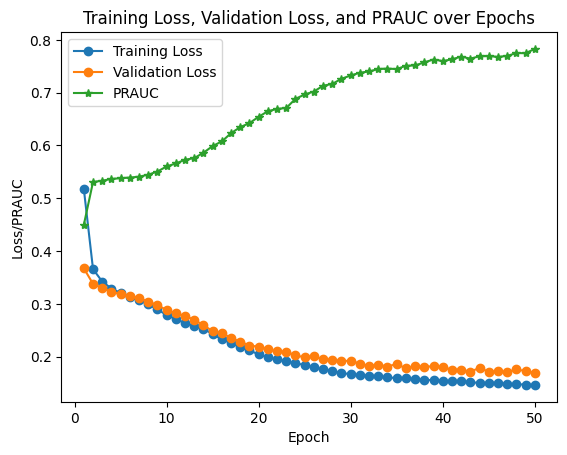

In [10]:
from pyhealth.trainer import Trainer

trainer = Trainer(model=model)
trainer.train(
    model_name="gnn",
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    epochs=50,
    optimizer_params = {"lr": 2 * 1e-4},
    monitor="pr_auc_samples",
    monitor_criterion="max",
)

### Results

loss: 0.0714
New best pr_auc_samples score (0.7785) at epoch-49, step-2550

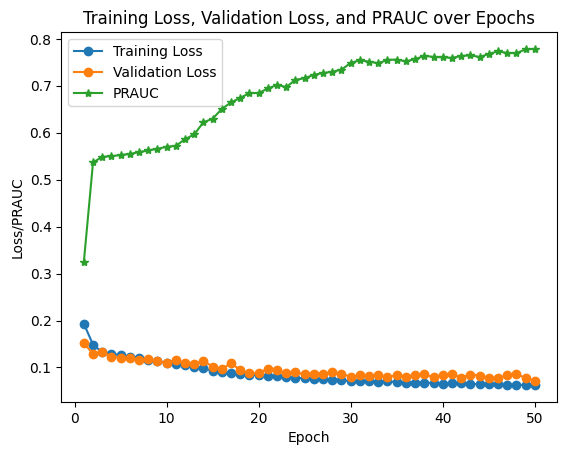

### Inference

In [11]:
from pyhealth.metrics import multilabel_metrics_fn

y_true, y_prob, loss = trainer.inference(test_loader)
print(loss)

Evaluation: 100%|██████████| 7/7 [00:01<00:00,  6.54it/s]

0.15457425639033318


In [12]:
print(y_true.shape)

print(y_true[y_true == 0].shape)
print(y_true[y_true == 1].shape)

(200, 406)
(75482,)
(5718,)


In [13]:
print(y_prob.shape)
print(y_prob.max())
print(y_prob.min())

(200, 406)
0.9998907
6.1621704e-13


In [14]:
print(y_true)
print("------------------")
threshold = 0.5
y_prob_threshold = (y_prob >= threshold).astype(float)
print(y_prob_threshold)
print(y_prob_threshold[y_prob_threshold == 0].shape)
print(y_prob_threshold[y_prob_threshold == 1].shape)

[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 1. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
------------------
[[0. 1. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 ...
 [0. 1. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
(67465,)
(13735,)


In [15]:
# risultati
metrics = ["accuracy", "f1_samples", "pr_auc_samples", "jaccard_samples", "precision_samples", "recall_samples"]
multilabel_metrics_fn(y_true, y_prob, metrics=metrics, threshold=0.5)

{'accuracy': 0.898435960591133,
 'f1_samples': 0.568359469065968,
 'pr_auc_samples': 0.7828398776050892,
 'jaccard_samples': 0.4119778575685856,
 'precision_samples': 0.4165912095307395,
 'recall_samples': 0.9801776874335935}

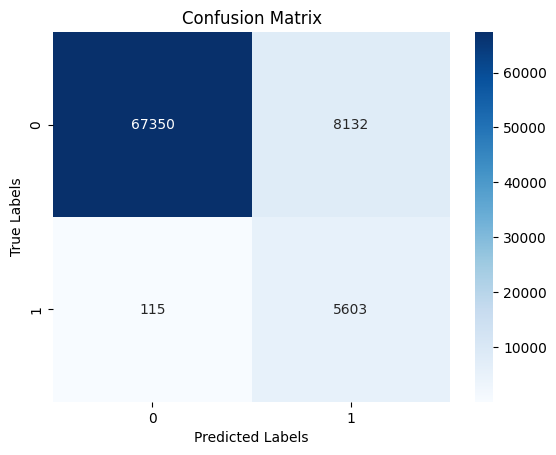

In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_true.flatten(), y_prob_threshold.flatten())

sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt=".0f")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

### Interpret with HeteroExplainer

In [139]:
from pyhealth.datasets import SampleEHRDataset

# Dizionario per tenere traccia dell'ultima visita per ciascun paziente
last_visit_per_patient = {}

# Iterare attraverso le visite
for visit in test_loader.dataset:
    patient_id = visit['patient_id']
    visit_id = visit['visit_id']

    # Se il paziente è già nel dizionario e la visita corrente è più recente, aggiorna
    if patient_id in last_visit_per_patient:
        if visit_id > last_visit_per_patient[patient_id]['visit_id']:
            last_visit_per_patient[patient_id] = visit
    else:
        # Altrimenti, aggiungi il paziente con la visita corrente
        last_visit_per_patient[patient_id] = visit

explain_dataset = SampleEHRDataset(list(last_visit_per_patient.values()), code_vocs="ATC")

In [17]:
print(f"Test originale: {len(test_ds)}; Test ridotto: {len(explain_dataset)}; Riduzione del {(100 * len(explain_dataset)) / len(test_ds)}%")

Test originale: 198; Test ridotto: 91; Riduzione del 45.95959595959596%


In [18]:
%load_ext autoreload
%autoreload 2

import importlib
import pyhealth.explainer

importlib.reload(pyhealth.explainer)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'pyhealth.explainer' from 'c:\\users\\giuse\\desktop\\msc-thesis-project\\proj_venv\\src\\pyhealth\\pyhealth\\explainer.py'>

In [38]:
from pyhealth.explainer import HeteroGraphExplainer

explainer = HeteroGraphExplainer(
    algorithm="GNNExplainer",
    dataset=test_loader.dataset,
    model=model,
    label_key="medications",
    threshold_value=15,
    top_k=15,
    feat_size=128,
)

In [20]:
patient_visit = explainer.subgraph['patient', 'visit'].edge_index
visit_drug = explainer.subgraph['visit', 'medication'].edge_index

patient_visit = patient_visit.T
visit_drug = visit_drug.T

# Creare un dizionario per tenere traccia del range di indici
index_range_per_patient_visit = {}
max_index = 0

# Iterare attraverso i dati
for pat_vis in patient_visit:
    # print(pat_vis)
    key = f"patient: {pat_vis[0]} - visit: {pat_vis[1]}"
    for vis_drug in visit_drug:
        # print(vis_drug)
        if vis_drug[0] == pat_vis[1]:
            if key in index_range_per_patient_visit:
                # Aggiornare l'indice massimo
                index_range_per_patient_visit[key][1] += 1
            else:
                # Aggiungere al dizionario con il range di indici
                index_range_per_patient_visit[key] = [max_index, max_index]
    max_index = index_range_per_patient_visit[key][1] + 1

# Stampare il range di indici per ciascun paziente
for key, index_range in index_range_per_patient_visit.items():
    print(f"Index range for {key} - n=[{index_range[0]} to {index_range[1]}]")

Index range for patient: 66 - visit: 148 - n=[0 to 14]
Index range for patient: 66 - visit: 149 - n=[15 to 28]
Index range for patient: 65 - visit: 146 - n=[29 to 51]
Index range for patient: 65 - visit: 147 - n=[52 to 78]
Index range for patient: 85 - visit: 188 - n=[79 to 103]
Index range for patient: 85 - visit: 189 - n=[104 to 138]
Index range for patient: 80 - visit: 176 - n=[139 to 158]
Index range for patient: 80 - visit: 177 - n=[159 to 195]
Index range for patient: 64 - visit: 142 - n=[196 to 235]
Index range for patient: 64 - visit: 143 - n=[236 to 251]
Index range for patient: 64 - visit: 144 - n=[252 to 278]
Index range for patient: 64 - visit: 145 - n=[279 to 316]
Index range for patient: 77 - visit: 170 - n=[317 to 342]
Index range for patient: 77 - visit: 171 - n=[343 to 365]
Index range for patient: 22 - visit: 53 - n=[366 to 398]
Index range for patient: 22 - visit: 54 - n=[399 to 420]
Index range for patient: 48 - visit: 109 - n=[421 to 441]
Index range for patient: 4

In [54]:
n=5801
explainer.explain(
    n=n
)

Loss: 0.25614
Generated explanations in ['node_mask', 'edge_mask']
Feature importance plot has been saved to './explainability_results/feature_importance_20240122_192000.png'
Edge to predict: tensor([109, 363])
Label to predict: 0
Label predicted: 0 because [0.03104696]


In [55]:
explainer.explain_graph(k=0, human_readable=False)
explainer.explain_graph(k=0, human_readable=True)

patient 48 Importance: tensor(0.7255)
visit 76 Importance: tensor(0.7852)
visit 109 Importance: tensor(0.7936)
symptom 1 Importance: tensor(0.2980)
symptom 6 Importance: tensor(0.3057)
symptom 19 Importance: tensor(0.3053)
symptom 21 Importance: tensor(0.3836)
symptom 34 Importance: tensor(0.5112)
symptom 65 Importance: tensor(0.3584)
symptom 66 Importance: tensor(0.3228)
symptom 67 Importance: tensor(0.3871)
symptom 86 Importance: tensor(0.5317)
symptom 87 Importance: tensor(0.3037)
symptom 88 Importance: tensor(0.5801)
symptom 110 Importance: tensor(0.3059)
symptom 143 Importance: tensor(0.3007)
symptom 168 Importance: tensor(0.3993)
procedure 13 Importance: tensor(0.6898)
procedure 21 Importance: tensor(0.6230)
procedure 35 Importance: tensor(0.6024)
procedure 74 Importance: tensor(0.7134)
procedure 177 Importance: tensor(0.6847)
procedure 178 Importance: tensor(0.6364)
diagnosis 40 Importance: tensor(0.6607)
diagnosis 49 Importance: tensor(0.6316)
diagnosis 62 Importance: tensor(0.

In [36]:
explainer.explain_metrics(metrics=["Fidelity", "Fidelity_F1", "Unfaithfulness", "Sparsity"])

Fidelity Positive: 0.2564408779144287
Fidelity Negative: 0.07041871547698975
Fidelity (weighted): 0.401986823257997
Unfaithfulness Score: 0.9074167683720589
Sparsity Score: 0.9319270253181458


In [53]:
explainer.explain_results(n=n, doctor_type="Internist_Doctor")
explainer.explain_results(n=n)

Your task is to explain why the system recommended medication Low-ceiling diuretics and potassium-sparing agents at visit 131 by analysing the scenario with your medical knowledge and to assess the RELEVANCE and CORRECTNESS of the medication hypothesis. 

The patient's medical scenario, in which the importance values of each condition are highlighted, is obtained from the explainability phase of the recommendation system, which aims to provide the conditions that the system has deemed important for recommendation purposes. In particular, the scenario includes:

Symptoms presented by the patient found to be important from the system (ordered by level of importance):

- Unspecified nutritional deficiency - Importance level: 0.3033
- Orthostatic hypotension - Importance level: 0.1634
- Paralysis agitans - Importance level: 0.161
- Anemia, unspecified - Importance level: 0.1521
- Unspecified disorder of kidney and ureter - Importance level: 0.1507
- Chest pain, unspecified - Importance lev

'You are a medical expert specialised in classifying a specific medical scenario in specific areas of medicine. \nGenerate a JSON file that lists a maximum of 5 MOST RELEVANT and COMPETENT doctors/specialists in the administration of the medication:\n"Low-ceiling diuretics and potassium-sparing agents" at visit 131 and on the patient\'s condition. \n\nThe patient\'s medical scenario, in which the importance values of each condition are highlighted, is obtained from the explainability phase of the recommendation system, which aims to provide the conditions that the system has deemed important for recommendation purposes. In particular, the scenario includes:\n\nSymptoms presented by the patient found to be important from the system (ordered by level of importance):\n\n- Unspecified nutritional deficiency - Importance level: 0.3033\n- Orthostatic hypotension - Importance level: 0.1634\n- Paralysis agitans - Importance level: 0.161\n- Anemia, unspecified - Importance level: 0.1521\n- Unsp

## Baseline Models

Here we can use the models having the same input built in the previous cells. We tried GRASP, SafeDrug, Transformer, and so on. And evaluate them performance with several metrics.

### RNN

**- RNN without symptoms**

In [ ]:
from pyhealth.models import RNN

model_rnn = RNN(
    dataset=mimic3sample,
    feature_keys=["conditions", "procedures"],
    label_key="drugs",
    mode="multilabel",
)

**- Training without symptoms**

In [ ]:
from pyhealth.trainer import Trainer

trainer_rnn = Trainer(model=model_rnn)
trainer_rnn.train(
    model_name="rnn",
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    epochs=10,
    optimizer_params = {"lr": 2 * 1e-4},
    monitor="pr_auc_samples",
)

loss: 0.2564
New best pr_auc_samples score (0.6729) at epoch-9, step-510

![image.png](attachment:image.png)

**- RNN Evaluation**

In [ ]:
### Without Symptoms - loss 0.3239 - time: 0m 6s
from pyhealth.metrics import multilabel_metrics_fn

y_true_rnn, y_prob_rnn, loss_rnn = trainer_rnn.inference(test_loader)
metrics = ["accuracy", "f1_samples", "pr_auc_samples", "jaccard_samples"]
multilabel_metrics_fn(y_true_rnn, y_prob_rnn, metrics=metrics)

Evaluation: 100%|██████████| 7/7 [00:00<00:00, 136.85it/s]


{'accuracy': 0.8959572593082177,
 'f1_samples': 0.5208913438646415,
 'pr_auc_samples': 0.6492154854289413,
 'jaccard_samples': 0.361292772853502}

### Transformer

**- Transformer without symptoms**

In [219]:
from pyhealth.models import Transformer

model_tr = Transformer(
    dataset=mimic3sample,
    feature_keys=["conditions", "procedures"],
    label_key="drugs",
    mode="multilabel",
)

**- Transformer with symptoms**

In [230]:
from pyhealth.models import Transformer

model_tr_symptoms = Transformer(
    dataset=mimic3sample,
    feature_keys=["conditions", "procedures", "symptoms"],
    label_key="drugs",
    mode="multilabel",
    heads=8,
)

**- Training without symptoms**

In [ ]:
from pyhealth.trainer import Trainer

trainer_tr = Trainer(model=model_tr)
trainer_tr.train(
    model_name="transformer",
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    epochs=10,
    optimizer_params = {"lr": 2 * 1e-4},
    monitor="pr_auc_samples",
)

loss: 0.2737
New best pr_auc_samples score (0.6465) at epoch-9, step-510

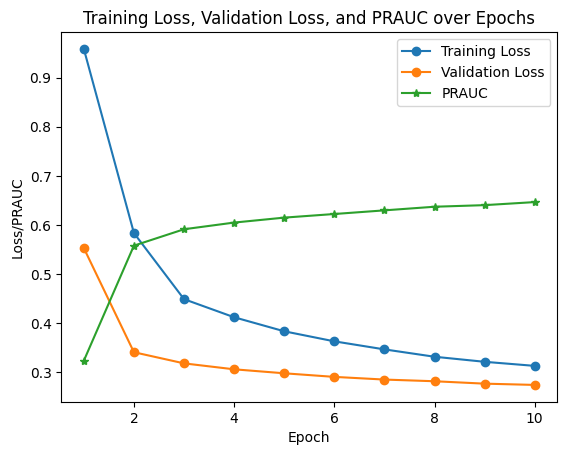

**- Training with symptoms**

Transformer(
  (embeddings): ModuleDict(
    (conditions): Embedding(2101, 128, padding_idx=0)
    (procedures): Embedding(735, 128, padding_idx=0)
    (symptoms): Embedding(716, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (conditions): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in_features=512, out_features=128, bias=True)
            (dropout): Dropout(p=0.5, inplace=False)
            (activation)

Epoch 0 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-0, step-51 ---
loss: 0.7998


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 78.56it/s]

--- Eval epoch-0, step-51 ---
pr_auc_samples: 0.3415
loss: 0.2854
New best pr_auc_samples score (0.3415) at epoch-0, step-51



Epoch 1 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-1, step-102 ---
loss: 0.3445


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 87.95it/s]

--- Eval epoch-1, step-102 ---
pr_auc_samples: 0.4794
loss: 0.2345
New best pr_auc_samples score (0.4794) at epoch-1, step-102



Epoch 2 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-2, step-153 ---
loss: 0.2997


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 77.02it/s]

--- Eval epoch-2, step-153 ---
pr_auc_samples: 0.4929
loss: 0.2212
New best pr_auc_samples score (0.4929) at epoch-2, step-153



Epoch 3 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-3, step-204 ---
loss: 0.2757


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 77.14it/s]

--- Eval epoch-3, step-204 ---
pr_auc_samples: 0.5068
loss: 0.2150
New best pr_auc_samples score (0.5068) at epoch-3, step-204



Epoch 4 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-4, step-255 ---
loss: 0.2603


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 85.27it/s]

--- Eval epoch-4, step-255 ---
pr_auc_samples: 0.5160
loss: 0.2090
New best pr_auc_samples score (0.5160) at epoch-4, step-255



Epoch 5 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-5, step-306 ---
loss: 0.2478


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 33.01it/s]


--- Eval epoch-5, step-306 ---
pr_auc_samples: 0.5233
loss: 0.2037
New best pr_auc_samples score (0.5233) at epoch-5, step-306



Epoch 6 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-6, step-357 ---
loss: 0.2351


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 54.56it/s]


--- Eval epoch-6, step-357 ---
pr_auc_samples: 0.5345
loss: 0.2011
New best pr_auc_samples score (0.5345) at epoch-6, step-357



Epoch 7 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-7, step-408 ---
loss: 0.2247


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 43.08it/s]


--- Eval epoch-7, step-408 ---
pr_auc_samples: 0.5399
loss: 0.1976
New best pr_auc_samples score (0.5399) at epoch-7, step-408



Epoch 8 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-8, step-459 ---
loss: 0.2178


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 58.73it/s]


--- Eval epoch-8, step-459 ---
pr_auc_samples: 0.5442
loss: 0.1944
New best pr_auc_samples score (0.5442) at epoch-8, step-459



Epoch 9 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-9, step-510 ---
loss: 0.2097


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 43.35it/s]


--- Eval epoch-9, step-510 ---
pr_auc_samples: 0.5517
loss: 0.1927
New best pr_auc_samples score (0.5517) at epoch-9, step-510



Epoch 10 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-10, step-561 ---
loss: 0.2017


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 57.53it/s]


--- Eval epoch-10, step-561 ---
pr_auc_samples: 0.5557
loss: 0.1908
New best pr_auc_samples score (0.5557) at epoch-10, step-561



Epoch 11 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-11, step-612 ---
loss: 0.1954


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 42.42it/s]


--- Eval epoch-11, step-612 ---
pr_auc_samples: 0.5579
loss: 0.1883
New best pr_auc_samples score (0.5579) at epoch-11, step-612



Epoch 12 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-12, step-663 ---
loss: 0.1907


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 63.88it/s]


--- Eval epoch-12, step-663 ---
pr_auc_samples: 0.5625
loss: 0.1872
New best pr_auc_samples score (0.5625) at epoch-12, step-663



Epoch 13 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-13, step-714 ---
loss: 0.1842


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 55.67it/s]


--- Eval epoch-13, step-714 ---
pr_auc_samples: 0.5655
loss: 0.1857
New best pr_auc_samples score (0.5655) at epoch-13, step-714



Epoch 14 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-14, step-765 ---
loss: 0.1798


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 59.20it/s]


--- Eval epoch-14, step-765 ---
pr_auc_samples: 0.5688
loss: 0.1847
New best pr_auc_samples score (0.5688) at epoch-14, step-765



Epoch 15 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-15, step-816 ---
loss: 0.1752


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 77.78it/s]

--- Eval epoch-15, step-816 ---
pr_auc_samples: 0.5704
loss: 0.1840
New best pr_auc_samples score (0.5704) at epoch-15, step-816



Epoch 16 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-16, step-867 ---
loss: 0.1736


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 55.92it/s]


--- Eval epoch-16, step-867 ---
pr_auc_samples: 0.5736
loss: 0.1824
New best pr_auc_samples score (0.5736) at epoch-16, step-867



Epoch 17 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-17, step-918 ---
loss: 0.1678


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 80.55it/s]

--- Eval epoch-17, step-918 ---
pr_auc_samples: 0.5759
loss: 0.1822
New best pr_auc_samples score (0.5759) at epoch-17, step-918



Epoch 18 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-18, step-969 ---
loss: 0.1635


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 52.11it/s]


--- Eval epoch-18, step-969 ---
pr_auc_samples: 0.5793
loss: 0.1827
New best pr_auc_samples score (0.5793) at epoch-18, step-969



Epoch 19 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-19, step-1020 ---
loss: 0.1607


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 77.72it/s]

--- Eval epoch-19, step-1020 ---
pr_auc_samples: 0.5792
loss: 0.1816



Epoch 20 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-20, step-1071 ---
loss: 0.1573


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 81.87it/s]

--- Eval epoch-20, step-1071 ---
pr_auc_samples: 0.5816
loss: 0.1816
New best pr_auc_samples score (0.5816) at epoch-20, step-1071



Epoch 21 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-21, step-1122 ---
loss: 0.1554


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 53.00it/s]


--- Eval epoch-21, step-1122 ---
pr_auc_samples: 0.5834
loss: 0.1814
New best pr_auc_samples score (0.5834) at epoch-21, step-1122



Epoch 22 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-22, step-1173 ---
loss: 0.1522


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 76.28it/s]

--- Eval epoch-22, step-1173 ---
pr_auc_samples: 0.5842
loss: 0.1809
New best pr_auc_samples score (0.5842) at epoch-22, step-1173



Epoch 23 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-23, step-1224 ---
loss: 0.1479


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 54.87it/s]


--- Eval epoch-23, step-1224 ---
pr_auc_samples: 0.5852
loss: 0.1801
New best pr_auc_samples score (0.5852) at epoch-23, step-1224



Epoch 24 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-24, step-1275 ---
loss: 0.1468


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 79.71it/s]

--- Eval epoch-24, step-1275 ---
pr_auc_samples: 0.5865
loss: 0.1822
New best pr_auc_samples score (0.5865) at epoch-24, step-1275



Epoch 25 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-25, step-1326 ---
loss: 0.1448


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 51.46it/s]


--- Eval epoch-25, step-1326 ---
pr_auc_samples: 0.5881
loss: 0.1828
New best pr_auc_samples score (0.5881) at epoch-25, step-1326



Epoch 26 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-26, step-1377 ---
loss: 0.1418


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 72.78it/s]

--- Eval epoch-26, step-1377 ---
pr_auc_samples: 0.5876
loss: 0.1834



Epoch 27 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-27, step-1428 ---
loss: 0.1402


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 52.40it/s]


--- Eval epoch-27, step-1428 ---
pr_auc_samples: 0.5877
loss: 0.1835



Epoch 28 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-28, step-1479 ---
loss: 0.1390


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 80.07it/s]

--- Eval epoch-28, step-1479 ---
pr_auc_samples: 0.5884
loss: 0.1846
New best pr_auc_samples score (0.5884) at epoch-28, step-1479



Epoch 29 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-29, step-1530 ---
loss: 0.1374


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 51.56it/s]


--- Eval epoch-29, step-1530 ---
pr_auc_samples: 0.5896
loss: 0.1841
New best pr_auc_samples score (0.5896) at epoch-29, step-1530



Epoch 30 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-30, step-1581 ---
loss: 0.1367


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 76.33it/s]

--- Eval epoch-30, step-1581 ---
pr_auc_samples: 0.5900
loss: 0.1853
New best pr_auc_samples score (0.5900) at epoch-30, step-1581



Epoch 31 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-31, step-1632 ---
loss: 0.1335


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 47.72it/s]


--- Eval epoch-31, step-1632 ---
pr_auc_samples: 0.5891
loss: 0.1856



Epoch 32 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-32, step-1683 ---
loss: 0.1336


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 73.59it/s]

--- Eval epoch-32, step-1683 ---
pr_auc_samples: 0.5905
loss: 0.1856


New best pr_auc_samples score (0.5905) at epoch-32, step-1683



Epoch 33 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-33, step-1734 ---
loss: 0.1326


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 74.67it/s]

--- Eval epoch-33, step-1734 ---
pr_auc_samples: 0.5910
loss: 0.1862
New best pr_auc_samples score (0.5910) at epoch-33, step-1734



Epoch 34 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-34, step-1785 ---
loss: 0.1300


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 72.13it/s]

--- Eval epoch-34, step-1785 ---
pr_auc_samples: 0.5908
loss: 0.1873


Epoch 35 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-35, step-1836 ---
loss: 0.1284


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 68.96it/s]

--- Eval epoch-35, step-1836 ---


pr_auc_samples: 0.5908
loss: 0.1856



Epoch 36 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-36, step-1887 ---
loss: 0.1272


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 47.14it/s]


--- Eval epoch-36, step-1887 ---
pr_auc_samples: 0.5918
loss: 0.1867
New best pr_auc_samples score (0.5918) at epoch-36, step-1887



Epoch 37 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-37, step-1938 ---
loss: 0.1267


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 68.24it/s]

--- Eval epoch-37, step-1938 ---
pr_auc_samples: 0.5918
loss: 0.1860



Epoch 38 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-38, step-1989 ---
loss: 0.1256


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 71.16it/s]

--- Eval epoch-38, step-1989 ---
pr_auc_samples: 0.5927
loss: 0.1865
New best pr_auc_samples score (0.5927) at epoch-38, step-1989


Epoch 39 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-39, step-2040 ---
loss: 0.1250


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 69.11it/s]

--- Eval epoch-39, step-2040 ---
pr_auc_samples: 0.5925
loss: 0.1855


Epoch 40 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-40, step-2091 ---
loss: 0.1240


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 41.97it/s]


--- Eval epoch-40, step-2091 ---
pr_auc_samples: 0.5933
loss: 0.1868
New best pr_auc_samples score (0.5933) at epoch-40, step-2091



Epoch 41 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-41, step-2142 ---
loss: 0.1235


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 61.26it/s]


--- Eval epoch-41, step-2142 ---
pr_auc_samples: 0.5936
loss: 0.1877
New best pr_auc_samples score (0.5936) at epoch-41, step-2142



Epoch 42 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-42, step-2193 ---
loss: 0.1223


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 71.64it/s]

--- Eval epoch-42, step-2193 ---
pr_auc_samples: 0.5955
loss: 0.1866
New best pr_auc_samples score (0.5955) at epoch-42, step-2193



Epoch 43 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-43, step-2244 ---
loss: 0.1219


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 52.00it/s]


--- Eval epoch-43, step-2244 ---
pr_auc_samples: 0.5950
loss: 0.1860



Epoch 44 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-44, step-2295 ---
loss: 0.1201


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 72.77it/s]

--- Eval epoch-44, step-2295 ---
pr_auc_samples: 0.5954
loss: 0.1865



Epoch 45 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-45, step-2346 ---
loss: 0.1197


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 56.69it/s]


--- Eval epoch-45, step-2346 ---
pr_auc_samples: 0.5936
loss: 0.1881



Epoch 46 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-46, step-2397 ---
loss: 0.1191


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 73.82it/s]

--- Eval epoch-46, step-2397 ---
pr_auc_samples: 0.5951
loss: 0.1883



Epoch 47 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-47, step-2448 ---
loss: 0.1193


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 71.00it/s]

--- Eval epoch-47, step-2448 ---
pr_auc_samples: 0.5933
loss: 0.1886


Epoch 48 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-48, step-2499 ---
loss: 0.1173


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 67.37it/s]


--- Eval epoch-48, step-2499 ---
pr_auc_samples: 0.5939
loss: 0.1926



Epoch 49 / 50:   0%|          | 0/51 [00:00<?, ?it/s]

--- Train epoch-49, step-2550 ---
loss: 0.1177


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 75.72it/s]

--- Eval epoch-49, step-2550 ---
pr_auc_samples: 0.5942
loss: 0.1889
Loaded best model


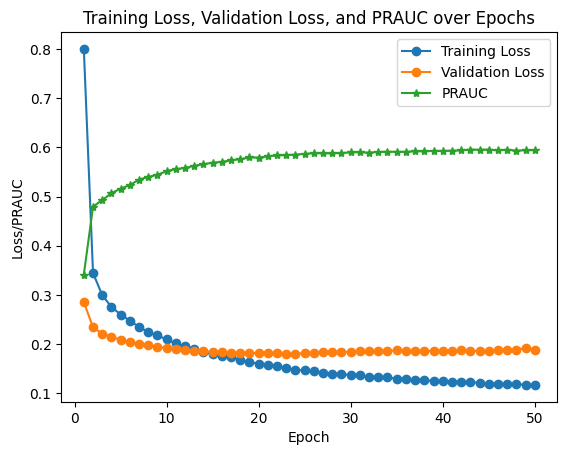

In [231]:
from pyhealth.trainer import Trainer

trainer_tr_symptoms = Trainer(model=model_tr_symptoms)
trainer_tr_symptoms.train(
    model_name="transformer",
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    epochs=50,
    optimizer_params = {"lr": 2 * 1e-4},
    monitor="pr_auc_samples",
    monitor_criterion="max",
)

**Transformer Results**

loss: 0.1799
New best pr_auc_samples score (0.5844) at epoch-40, step-2091

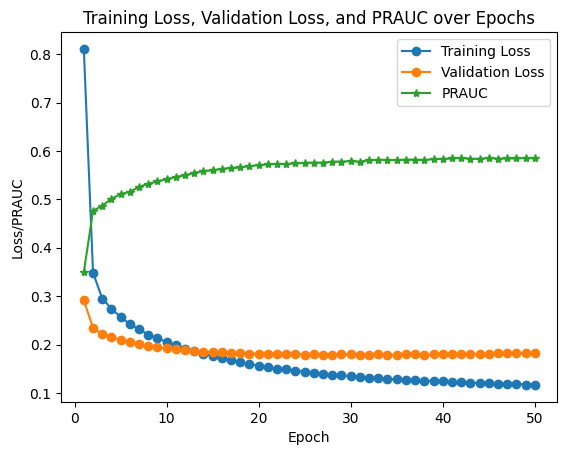

**- Transformer Evaluation**

In [223]:
### Without Symptoms - loss 0.3239 - time: 0m 6s
from pyhealth.metrics import multilabel_metrics_fn

y_true_tr, y_prob_tr, loss_tr = trainer_tr.inference(test_loader)
metrics = ["accuracy", "f1_samples", "pr_auc_samples", "jaccard_samples"]
multilabel_metrics_fn(y_true_tr, y_prob_tr, metrics=metrics)

Evaluation: 100%|██████████| 7/7 [00:00<00:00, 64.07it/s]


{'accuracy': 0.8929554968054637,
 'f1_samples': 0.5066958446595764,
 'pr_auc_samples': 0.6258955924552839,
 'jaccard_samples': 0.34884642635231966}

In [232]:
### With Symptoms - loss 0.3192 - time: 0m 9s
from pyhealth.metrics import multilabel_metrics_fn

y_true_tr_s, y_prob_tr_s, loss_tr_s = trainer_tr_symptoms.inference(test_loader)
metrics = ["accuracy", "f1_samples", "pr_auc_samples", "jaccard_samples"]
multilabel_metrics_fn(y_true_tr_s, y_prob_tr_s, metrics=metrics)

Evaluation: 100%|██████████| 7/7 [00:00<00:00, 68.42it/s]


{'accuracy': 0.9436140814610117,
 'f1_samples': 0.48076371753279945,
 'pr_auc_samples': 0.5973332837448941,
 'jaccard_samples': 0.3303265243284095}

### SafeDrug

**- SafeDrug without symptoms**

In [225]:
from pyhealth.models import SafeDrug

model_safe = SafeDrug(
    dataset=mimic3sample
)

**- SafeDrug with symptoms**

In [226]:
from pyhealth.models import SafeDrug_Mod

model_safe_symptoms = SafeDrug_Mod(
    dataset=mimic3sample
)

**- Training without symptoms**

In [ ]:
from pyhealth.trainer import Trainer

trainer_safe = Trainer(model=model_safe)
trainer_safe.train(
    model_name="safedrug",
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    epochs=10,
    optimizer_params = {"lr": 2 * 1e-4},
    monitor="pr_auc_samples",
)

loss: 0.2503
New best pr_auc_samples score (0.6564) at epoch-8, step-459

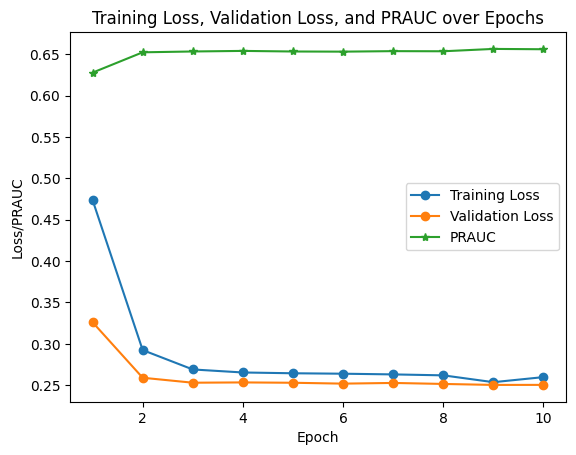

**- Training with symptoms**

In [ ]:
from pyhealth.trainer import Trainer

trainer_safe_symptoms = Trainer(model=model_safe_symptoms)
trainer_safe_symptoms.train(
    model_name="safedrug",
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    epochs=10,
    optimizer_params = {"lr": 2 * 1e-4},
    monitor="pr_auc_samples",
)

loss: 0.2523
New best pr_auc_samples score (0.6550) at epoch-6, step-357

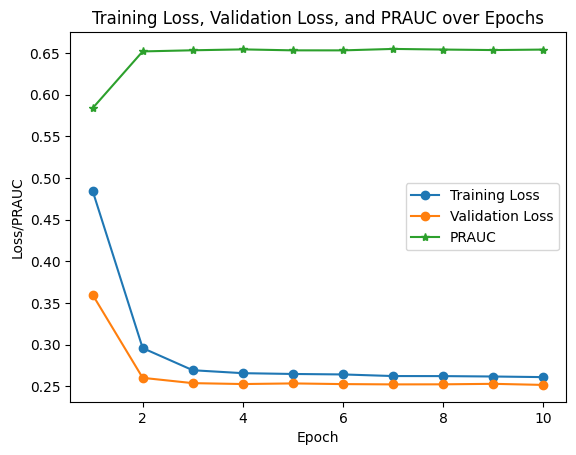

**- SafeDrug Evaluation**

In [229]:
### Without Symptoms - loss 0.2672 - time: 2m 6s
from pyhealth.metrics import multilabel_metrics_fn

y_true_safe, y_prob_safe, loss_safe = trainer_safe.inference(test_loader)
metrics = ["accuracy", "f1_samples", "pr_auc_samples", "jaccard_samples"]
multilabel_metrics_fn(y_true_safe, y_prob_safe, metrics=metrics)

Evaluation: 100%|██████████| 7/7 [00:02<00:00,  2.46it/s]


{'accuracy': 0.8926801057501652,
 'f1_samples': 0.46661275056800083,
 'pr_auc_samples': 0.6270758763872015,
 'jaccard_samples': 0.31076166173689124}

In [230]:
### With Symptoms - loss 0.2666 - time: 2m 0s
from pyhealth.metrics import multilabel_metrics_fn

y_true_safe_s, y_prob_safe_s, loss_safe_s = trainer_safe_symptoms.inference(test_loader)
metrics = ["accuracy", "f1_samples", "pr_auc_samples", "jaccard_samples"]
multilabel_metrics_fn(y_true_safe_s, y_prob_safe_s, metrics=metrics)

Evaluation: 100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


{'accuracy': 0.8925148711169861,
 'f1_samples': 0.47263706593544114,
 'pr_auc_samples': 0.6248807689518094,
 'jaccard_samples': 0.3164571303390051}

### GAMENet

### GRASP

### RETAIN

### MICRON

### MoleRec

## Let'see some recommendation...

In [ ]:
import numpy as np
import pandas as pd
from pyhealth.medcode import InnerMap

# initialize an InnerMap
atc = InnerMap.load("ATC")

sorted_indices = []
for i in range(len(y_prob)):
    top_indices = np.argsort(y_prob[i, :])[::-1][:10]
    sorted_values = y_prob[i, top_indices]
    sorted_indices.append(top_indices)

patient_ids = []
visit_ids = []
rec_drug = []

# get the list of all drugs in the dataset
list_drugs = mimic3sample.get_all_tokens('drugs')

# iterate over the top indexes for each sample in test_ds
for sample, top in zip(test_ds, sorted_indices):
   
    # append the patient id and visit id to their respective lists
    patient_ids.append(sample['patient_id'])
    visit_ids.append(sample['visit_id'])
   
    # create an empty list to store the recommended drugs for this sample
    sample_rec_drug = []
   
    # iterate over the top indexes for this sample
    for i in top:
       
        # append the drug at the i-th index to the recommended drugs list for this sample
        sample_rec_drug.append(list_drugs[i])
   
    # append the recommended drugs for this sample to the recommended drugs list
    rec_drug.append(sample_rec_drug)

# create a dataframe with the patient ids, visit ids, and recommended drugs
df_rec_drug = pd.DataFrame({'patient_id': patient_ids, 'visit_id': visit_ids, 'rec_drug': rec_drug})
df_rec_drug

In [125]:
from pyhealth.medcode import InnerMap

# initialize an InnerMap
atc = InnerMap.load("ATC")

# select a patient from df_rec_drug
patient_id = 10884
visit_id = 150905
patient_df = df_rec_drug[df_rec_drug['patient_id'].astype(int)==patient_id]
patient_df = patient_df[patient_df['visit_id'].astype(int)==visit_id]

# iterate over the recommended drugs for the selected patient
for drugs in patient_df['rec_drug']:
    # lookup the ATC code for each drug and print it
    for drug in drugs:
        print(f"{drug}: {atc.lookup(drug)}")

B05XA: Electrolyte solutions
N03AX: Other antiepileptics in ATC
M04AC: Preparations with no effect on uric acid metabolism
M03BA: Carbamic acid esters, centrally acting muscle relaxants
G04CA: Alpha-adrenoreceptor antagonists, benign prostatic hypertrophy
J01EE: Combinations of sulfonamides and trimethoprim, incl. derivatives
N02BE: Anilide analgesics and antipyretics
B01AB: Heparin group antithrombotic drugs
N05CF: Benzodiazepine related hypnotics and sedatives
A02BC: Proton pump inhibitors for peptic ulcer and GORD


In [124]:
from pyhealth.medcode import InnerMap

# select a patient from df_rec_drug
patient_id = 10884
visit_id = 150905

for sample in test_ds:
    if (sample['patient_id'] == str(patient_id)) and (sample['visit_id'] == str(visit_id)):
        conditions = sample['conditions']
        procedures = sample['procedures']
        symptoms = sample['symptoms']

# initialize an InnerMap
icd9cm = InnerMap.load("ICD9CM")
i=0
for condition in conditions:
    for code in condition:
        print(f"Condition {i}: {icd9cm.lookup(code)}")
        i+=1

# initialize an InnerMap
icd9pr = InnerMap.load("ICD9PROC")
i=0
for procedure in procedures:
    for code in procedure:
        print(f"Procedure {i}: {icd9pr.lookup(code)}")
        i+=1

i=0
for symptom in symptoms:
    for code in symptom:
        print(f"Symptom {i}: {icd9cm.lookup(code)}")
        i+=1

Condition 0: Acute and subacute necrosis of liver
Condition 1: Alcoholic cirrhosis of liver
Condition 2: Hepatorenal syndrome
Condition 3: Acute kidney failure with lesion of tubular necrosis
Condition 4: Congestive heart failure, unspecified
Condition 5: Hyposmolality and/or hyponatremia
Condition 6: Chronic kidney disease, unspecified
Condition 7: Toxic encephalopathy
Condition 8: Hepatic encephalopathy
Condition 9: Calculus of gallbladder with other cholecystitis, without mention of obstruction
Condition 10: Ascites
Condition 11: Acquired coagulation factor deficiency
Condition 12: Thrombocytopenia, unspecified
Condition 13: Unspecified essential hypertension
Condition 14: Other specified disorders of pancreatic internal secretion
Condition 15: Adrenal cortical steroids causing adverse effects in therapeutic use
Condition 16: Acute alcoholic intoxication in alcoholism, in remission
Condition 17: Esophageal reflux
Condition 18: Personal history of urinary calculi
Condition 19: Aphasi